## importar bibliotecas

In [50]:
import requests
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from ydata_profiling import ProfileReport
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from itertools import combinations
import math
%matplotlib inline
pd.set_option('display.float_format', '{:.2f}'.format)

## importar e limpar dados

### dÃ³lar, ibov, marfrig, jbs, brf

In [2]:
ativos = { #lista de ativos com seus respectivos tickers
    "dolar": "USDBRL=X",
    "ibov": "^BVSP",
    "marfrig": "MRFG3.SA",
    "jbs": "JBSS3.SA",
    "brf": "BEEF3.SA"
}

dfs = {} #dicionÃ¡rio para armazenar os DataFrames de cada ativo

for nome, ticker in ativos.items():
    config = yf.Ticker(ticker)
    df = config.history(start="2009-12-30", end="2024-12-31", interval="1d").reset_index() #define a data de inÃ­cio e fim
    df = df.resample('MS', on='Date').first().reset_index() #resample para pegar o primeiro valor de cada mÃªs
    df = df[['Date','Close']] #seleciona apenas as colunas Date e Close
    df['Close'] = df['Close'].astype(float) #covnerte a coluna Close para float
    df[f'var_%_{nome}'] = ((df['Close'] - df['Close'].shift(1)) / df['Close'].shift(1)) * 100 #calcula a variaÃ§Ã£o percentual
    df = df.dropna(subset=[f'var_%_{nome}']) #remove linhas com NaN na coluna var_percent
    df['Date'] = df['Date'].dt.strftime('%b/%Y').str.lower() #formata a coluna Date para o formato desejado
    df = df.rename(columns={ #renomeia as colunas
        'Close': f'close_{nome}', 
        'Date':'data'
        }) 
    dfs[nome] = df #atribui o DataFrame ao dicionÃ¡rio dfs com o nome do ativo como chave
    print(f"DataFrame df_{nome} criado\n")

#acessar os DataFrames individuais
df_dolar = dfs["dolar"]
df_ibov = dfs["ibov"]
df_marfrig = dfs["marfrig"]
df_jbs = dfs["jbs"]
df_brf = dfs["brf"]

DataFrame df_dolar criado

DataFrame df_ibov criado

DataFrame df_marfrig criado

DataFrame df_jbs criado

DataFrame df_brf criado



### IPCA

In [3]:
#consultar Ã  API do Banco Central (IPCA)
url = "https://api.bcb.gov.br/dados/serie/bcdata.sgs.433/dados"
params = {"formato": "json"}
response = requests.get(url, params=params)
dados_json = response.json()

#converter para DataFrame
df_ipca = pd.DataFrame(dados_json)

#converter 'data' para datetime e filtra intervalo de anos
df_ipca['data'] = pd.to_datetime(df_ipca.data, format='%d/%m/%Y')
df_ipca = df_ipca[(df_ipca.data.dt.year >= 2009) & (df_ipca.data.dt.year <= 2024)]

#converter valores para float
df_ipca['valor'] = df_ipca.valor.astype(float)

#calcular variaÃ§Ã£o percentual mÃªs a mÃªs
df_ipca['var_%_ipca'] = df_ipca.valor.pct_change() * 100
df_ipca = df_ipca.dropna(subset=['var_%_ipca'])

#filtrar apenas ano != de 2009
df_ipca = df_ipca[df_ipca.data.dt.year != 2009]

#formatar a colouna de data para o formato mÃªs/ano
df_ipca['data'] = df_ipca.data.dt.strftime('%b/%Y').str.lower()

#renomear colunas finais
df_ipca = df_ipca.rename(columns={
    'valor': 'value_ipca'
})

#resetar o Ã­ndice do DataFrame
df_ipca = df_ipca.reset_index(drop=True)
#exibir dataframe
df_ipca.head()

data  value_ipca  var_%_ipca
0  jan/2010        0.75      102.70
1  feb/2010        0.78        4.00
2  mar/2010        0.52      -33.33
3  apr/2010        0.57        9.62
4  may/2010        0.43      -24.56

### balanÃ§a comercial

In [4]:
# importar dataframe
df_balanca_comercial = pd.read_excel(r'balanca_comercial.xlsx')

#multiplicar coluna de var_percent por 100 e dropar coluna var_percent_balanca_com
df_balanca_comercial['var_%_balanca_com'] = df_balanca_comercial['var_percent_balanca_com']*100
del df_balanca_comercial['var_percent_balanca_com']

#retirar anos desnecessÃ¡rio
df_balanca_comercial['ano'] = df_balanca_comercial.mÃªs_ano.str[3:7]
df_balanca_comercial = df_balanca_comercial[df_balanca_comercial.ano!='2009']

#adiciona o dia como '01' no inÃ­cio da string para formar uma data vÃ¡lida
df_balanca_comercial['mÃªs_ano'] = '01/' + df_balanca_comercial.mÃªs_ano
df_balanca_comercial['mÃªs_ano'] = pd.to_datetime(df_balanca_comercial.mÃªs_ano, format='%d/%m/%Y')

#formatar a colouna de mÃªs_ano para o formato mÃªs/ano
df_balanca_comercial['mÃªs_ano'] = df_balanca_comercial.mÃªs_ano.dt.strftime('%b/%Y').str.lower()
del df_balanca_comercial['ano']

#renomear colunas finais
df_balanca_comercial = df_balanca_comercial.rename(columns={
    'mÃªs_ano':'data',
    'saldo_balanca':'saldo_balanca_com',
})

#exibir dataframe
df_balanca_comercial.head()

data  saldo_balanca_com  var_%_balanca_com
0  dec/2024     20245157064.00               4.28
1  nov/2024     21110834322.00              19.42
2  oct/2024     25209647872.00              -7.21
3  sep/2024     23391814867.00               3.54
4  aug/2024     24219210009.00              -3.84

### exportaÃ§Ã£o carnes

In [5]:
# importar dataframe
df_balanca_carnes = pd.read_excel(r'balanca_carnes.xlsx')

#multiplicar coluna de var_percent por 100
df_balanca_carnes['var_percent_balanca_carnes'] = df_balanca_carnes['var_percent_balanca_carnes']*100

#retirar anos desnecessÃ¡rio
df_balanca_carnes['ano'] = df_balanca_carnes.mÃªs_ano.str[3:7]
df_balanca_carnes = df_balanca_carnes[df_balanca_carnes.ano!='2009']

#adiciona o dia como '01' no inÃ­cio da string para formar uma data vÃ¡lida
df_balanca_carnes['mÃªs_ano'] = '01/' + df_balanca_carnes.mÃªs_ano
df_balanca_carnes['mÃªs_ano'] = pd.to_datetime(df_balanca_carnes.mÃªs_ano, format='%d/%m/%Y')

#formatar a colouna de mÃªs_ano para o formato mÃªs/ano
df_balanca_carnes['mÃªs_ano'] = df_balanca_carnes.mÃªs_ano.dt.strftime('%b/%Y').str.lower()
del df_balanca_carnes['ano']

#renomear colunas finais
df_balanca_carnes = df_balanca_carnes.rename(columns={
    'mÃªs_ano':'data',
    'valor_exportado':'value_exp_carnes',
    'var_percent_balanca_carnes': 'var_%_exp_carnes'
})

#exibir dataframe
df_balanca_carnes.head()

data  value_exp_carnes  var_%_exp_carnes
0  dec/2024     1002973520.00             10.80
1  nov/2024     1111331127.00             13.37
2  oct/2024     1259866861.00             -9.85
3  sep/2024     1135823209.00            -15.10
4  aug/2024      964290196.00              8.46

In [6]:
#juntar os DataFrames em um Ãºnico DataFrame pela coluna 'data' considerando apenas a coluna que comeÃ§a com 'var'
df_final_var = df_dolar[['data','var_%_dolar']].merge(df_ibov[['data','var_%_ibov']], on='data', how='outer') \
                   .merge(df_marfrig[['data','var_%_marfrig']], on='data', how='outer') \
                   .merge(df_jbs[['data','var_%_jbs']], on='data', how='outer') \
                   .merge(df_brf[['data','var_%_brf']], on='data', how='outer') \
                   .merge(df_ipca[['data','var_%_ipca']], on='data', how='outer') \
                   .merge(df_balanca_comercial[['data','var_%_balanca_com']], on='data', how='outer') \
                   .merge(df_balanca_carnes[['data','var_%_exp_carnes']], on='data', how='outer')
#exibir o DataFrame final
df_final_var

data  var_%_dolar  var_%_ibov  var_%_marfrig  var_%_jbs  var_%_brf  \
0    apr/2010        -1.81        5.81          -7.32     -11.52      13.64   
1    apr/2011        -1.90        4.57          -2.50      -5.76       0.89   
2    apr/2012         6.36       -2.39          11.74      -2.24      20.43   
3    apr/2013         2.09       -1.73         -11.70       2.73       2.75   
4    apr/2014        -2.75        7.90          10.20       0.53      -5.56   
..        ...          ...         ...            ...        ...        ...   
175  sep/2020         5.17       -0.64          18.62      -0.89      -3.80   
176  sep/2021        -1.14       -2.55           8.54      -3.05      -8.57   
177  sep/2022         0.20        8.00           4.34      -8.58      16.92   
178  sep/2023         4.85       -2.77          -0.64      -2.68     -14.66   
179  sep/2024        -0.84        5.95          18.84       4.86      12.07   

     var_%_ipca  var_%_balanca_com  var_%_exp_carnes  
0          9.62               8.38             -2.75  
1         -2.53              -3.18             15.28  
2        204.76               0.98             -0.82  
3         17.02             -11.50             -9.79  
4        -27.17              -8.85             -9.63  
..          ...                ...               ...  
175      166.67             -11.83             12.19  
176       33.33              -2.09             -4.70  
177      -19.44               7.18              2.29  
178       13.04               9.92             -5.56  
179    -2300.00               3.54            -15.10  

[180 rows x 9 columns]

In [7]:
#juntar os DataFrames em um Ãºnico DataFrame pela coluna 'data' considerando apenas a coluna que comeÃ§a com 'value'
df_final_value = df_dolar[['data','close_dolar']].merge(df_ibov[['data','close_ibov']], on='data', how='outer') \
                   .merge(df_marfrig[['data','close_marfrig']], on='data', how='outer') \
                   .merge(df_jbs[['data','close_jbs']], on='data', how='outer') \
                   .merge(df_brf[['data','close_brf']], on='data', how='outer') \
                   .merge(df_ipca[['data','value_ipca']], on='data', how='outer') \
                   .merge(df_balanca_comercial[['data','saldo_balanca_com']], on='data', how='outer') \
                   .merge(df_balanca_carnes[['data','value_exp_carnes']], on='data', how='outer')
#exibir o DataFrame final
df_final_value

data  close_dolar  close_ibov  close_marfrig  close_jbs  close_brf  \
0    apr/2010         1.77    71136.00          11.30       4.92       5.52   
1    apr/2011         1.63    69268.00           7.90       3.57       4.79   
2    apr/2012         1.83    65216.00           6.70       4.77       5.71   
3    apr/2013         2.02    55902.00           4.68       4.11       9.98   
4    apr/2014         2.27    50270.00           2.50       4.63       7.50   
..        ...          ...         ...            ...        ...        ...   
175  sep/2020         5.49   102168.00           9.69      15.08      10.24   
176  sep/2021         5.15   119396.00          12.24      22.49       7.20   
177  sep/2022         5.18   110405.00           9.86      22.75      14.32   
178  sep/2023         4.95   117893.00           6.31      15.91       8.56   
179  sep/2024         5.61   134981.00          11.95      31.10       7.24   

     value_ipca  saldo_balanca_com  value_exp_carnes  
0          0.57     14007783168.00      300196785.00  
1          0.77     18458870399.00      340074636.00  
2          0.64     18849751858.00      342856574.00  
3          0.55     21788737806.00      435799881.00  
4          0.67     19352300589.00      422337850.00  
..          ...                ...               ...  
175        0.64     13139951686.00      583051614.00  
176        1.16     19975447581.00     1082417249.00  
177       -0.29     24892711361.00     1218097312.00  
178        0.26     19531513320.00      884925708.00  
179        0.44     23391814867.00     1135823209.00  

[180 rows x 9 columns]

## analise exploratÃ³ria

In [8]:
#criar o perfil do DataFrame
profile = ProfileReport(df_final_value, title="RelatÃ³rio Pandas Profiling", explorative=True)

#exportar como HTML
profile.to_file("relatorio_pandas_profiling.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 9/9 [00:00<00:00, 308.46it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### heatmap de correlaÃ§Ã£o

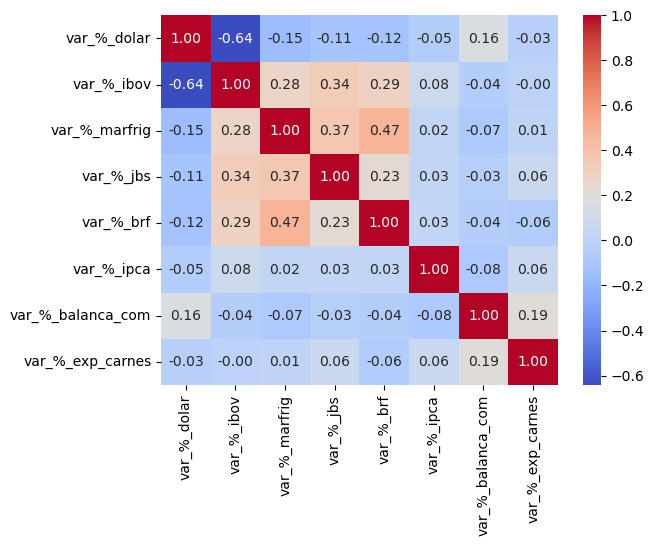

In [9]:
#analisar a matriz de correlaÃ§Ã£o (heatmap) retirando a coluna 'data' do dataframe final de variaÃ§Ã£o percentual
sns.heatmap(df_final_var.drop(['data'],axis=1).corr(),annot=True, cmap="coolwarm",fmt='.2f');

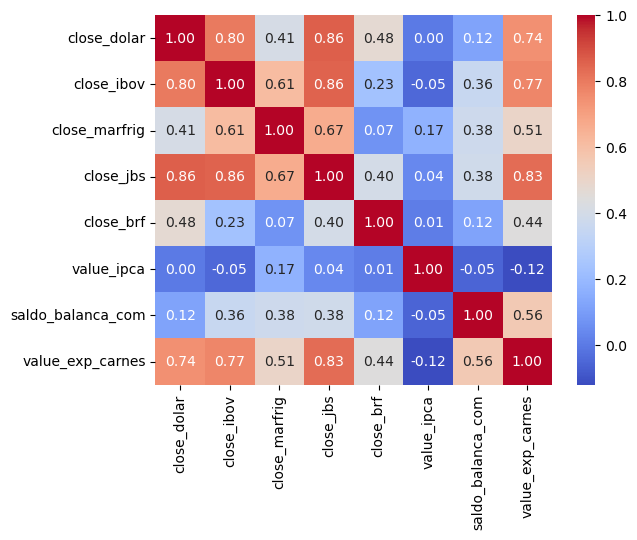

In [10]:
#analisar a matriz de correlaÃ§Ã£o (heatmap) retirando a coluna 'data' do dataframe final de valores
sns.heatmap(df_final_value.drop(['data'],axis=1).corr(),annot=True, cmap="coolwarm",fmt='.2f');

### histograma de valores

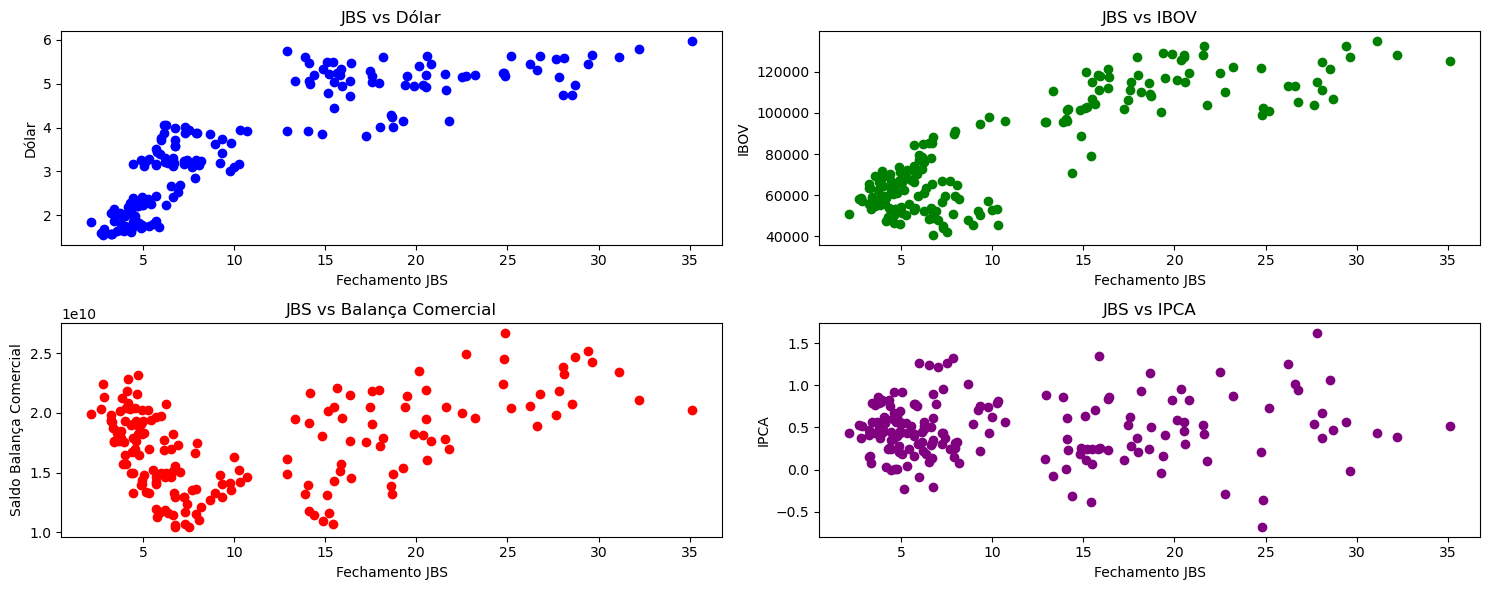

In [11]:
# Criar figura com 2 linhas e 2 colunas (4 grÃ¡ficos)
fig, ax = plt.subplots(2, 2, figsize=(15,6))

# 1. JBS vs DÃ³lar
ax[0, 0].scatter(df_final_value['close_jbs'], df_final_value['close_dolar'], color='blue')
ax[0, 0].set_title("JBS vs DÃ³lar")
ax[0, 0].set_xlabel("Fechamento JBS")
ax[0, 0].set_ylabel("DÃ³lar")

# 2. JBS vs IBOV
ax[0, 1].scatter(df_final_value['close_jbs'], df_final_value['close_ibov'], color='green')
ax[0, 1].set_title("JBS vs IBOV")
ax[0, 1].set_xlabel("Fechamento JBS")
ax[0, 1].set_ylabel("IBOV")

# 3. JBS vs BalanÃ§a Comercial
ax[1, 0].scatter(df_final_value['close_jbs'], df_final_value['saldo_balanca_com'], color='red')
ax[1, 0].set_title("JBS vs BalanÃ§a Comercial")
ax[1, 0].set_xlabel("Fechamento JBS")
ax[1, 0].set_ylabel("Saldo BalanÃ§a Comercial")

# 4. JBS vs IPCA
ax[1, 1].scatter(df_final_value['close_jbs'], df_final_value['value_ipca'], color='purple')
ax[1, 1].set_title("JBS vs IPCA")
ax[1, 1].set_xlabel("Fechamento JBS")
ax[1, 1].set_ylabel("IPCA")

plt.tight_layout()
plt.show()

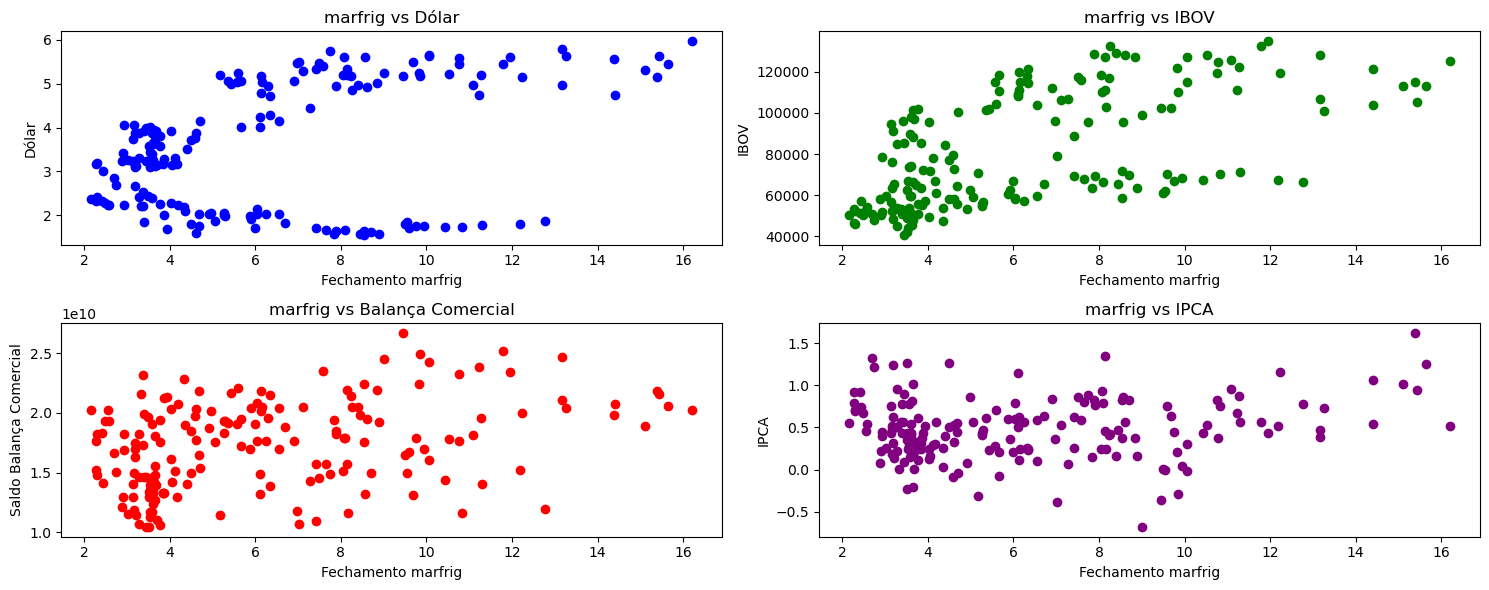

In [12]:
# Criar figura com 2 linhas e 2 colunas (4 grÃ¡ficos)
fig, ax = plt.subplots(2, 2, figsize=(15,6))

# 1. marfrig vs DÃ³lar
ax[0, 0].scatter(df_final_value['close_marfrig'], df_final_value['close_dolar'], color='blue')
ax[0, 0].set_title("marfrig vs DÃ³lar")
ax[0, 0].set_xlabel("Fechamento marfrig")
ax[0, 0].set_ylabel("DÃ³lar")

# 2. marfrig vs IBOV
ax[0, 1].scatter(df_final_value['close_marfrig'], df_final_value['close_ibov'], color='green')
ax[0, 1].set_title("marfrig vs IBOV")
ax[0, 1].set_xlabel("Fechamento marfrig")
ax[0, 1].set_ylabel("IBOV")

# 3. marfrig vs BalanÃ§a Comercial
ax[1, 0].scatter(df_final_value['close_marfrig'], df_final_value['saldo_balanca_com'], color='red')
ax[1, 0].set_title("marfrig vs BalanÃ§a Comercial")
ax[1, 0].set_xlabel("Fechamento marfrig")
ax[1, 0].set_ylabel("Saldo BalanÃ§a Comercial")

# 4. marfrig vs IPCA
ax[1, 1].scatter(df_final_value['close_marfrig'], df_final_value['value_ipca'], color='purple')
ax[1, 1].set_title("marfrig vs IPCA")
ax[1, 1].set_xlabel("Fechamento marfrig")
ax[1, 1].set_ylabel("IPCA")

plt.tight_layout()
plt.show()

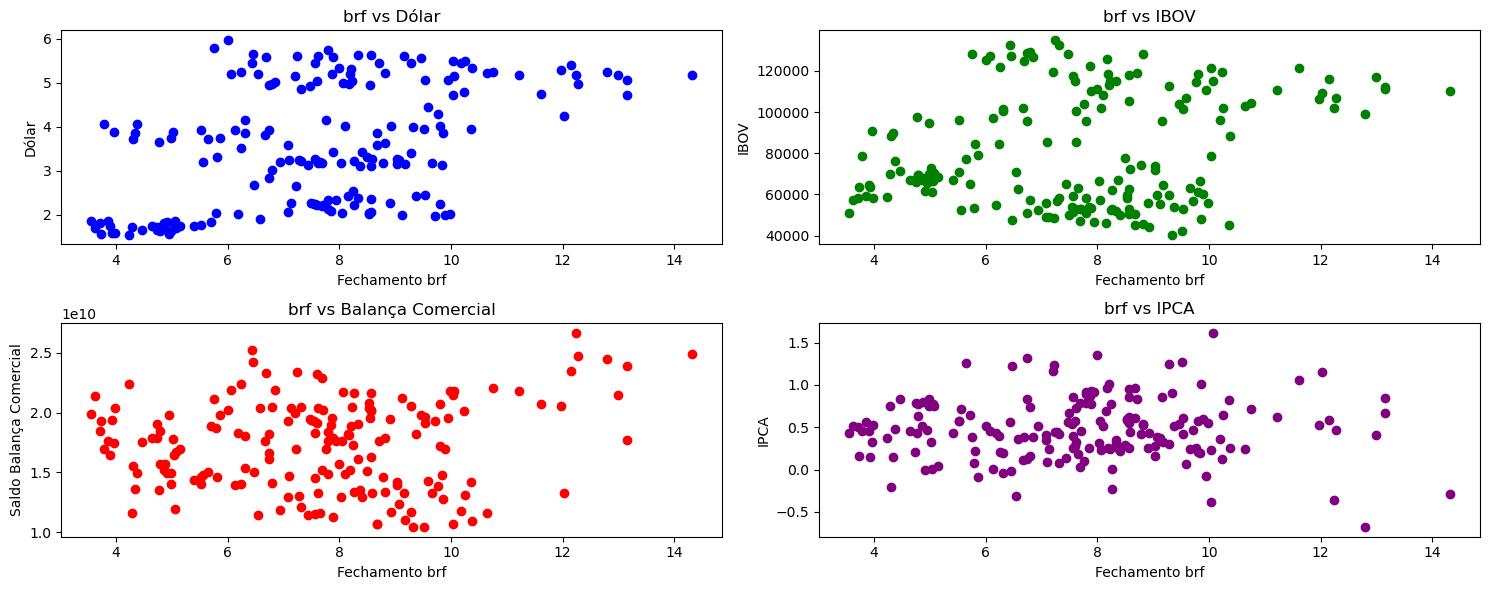

In [13]:
# Criar figura com 2 linhas e 2 colunas (4 grÃ¡ficos)
fig, ax = plt.subplots(2, 2, figsize=(15,6))

# 1. brf vs DÃ³lar
ax[0, 0].scatter(df_final_value['close_brf'], df_final_value['close_dolar'], color='blue')
ax[0, 0].set_title("brf vs DÃ³lar")
ax[0, 0].set_xlabel("Fechamento brf")
ax[0, 0].set_ylabel("DÃ³lar")

# 2. brf vs IBOV
ax[0, 1].scatter(df_final_value['close_brf'], df_final_value['close_ibov'], color='green')
ax[0, 1].set_title("brf vs IBOV")
ax[0, 1].set_xlabel("Fechamento brf")
ax[0, 1].set_ylabel("IBOV")

# 3. brf vs BalanÃ§a Comercial
ax[1, 0].scatter(df_final_value['close_brf'], df_final_value['saldo_balanca_com'], color='red')
ax[1, 0].set_title("brf vs BalanÃ§a Comercial")
ax[1, 0].set_xlabel("Fechamento brf")
ax[1, 0].set_ylabel("Saldo BalanÃ§a Comercial")

# 4. brf vs IPCA
ax[1, 1].scatter(df_final_value['close_brf'], df_final_value['value_ipca'], color='purple')
ax[1, 1].set_title("brf vs IPCA")
ax[1, 1].set_xlabel("Fechamento brf")
ax[1, 1].set_ylabel("IPCA")

plt.tight_layout()
plt.show()

### histograma de variaÃ§Ã£o

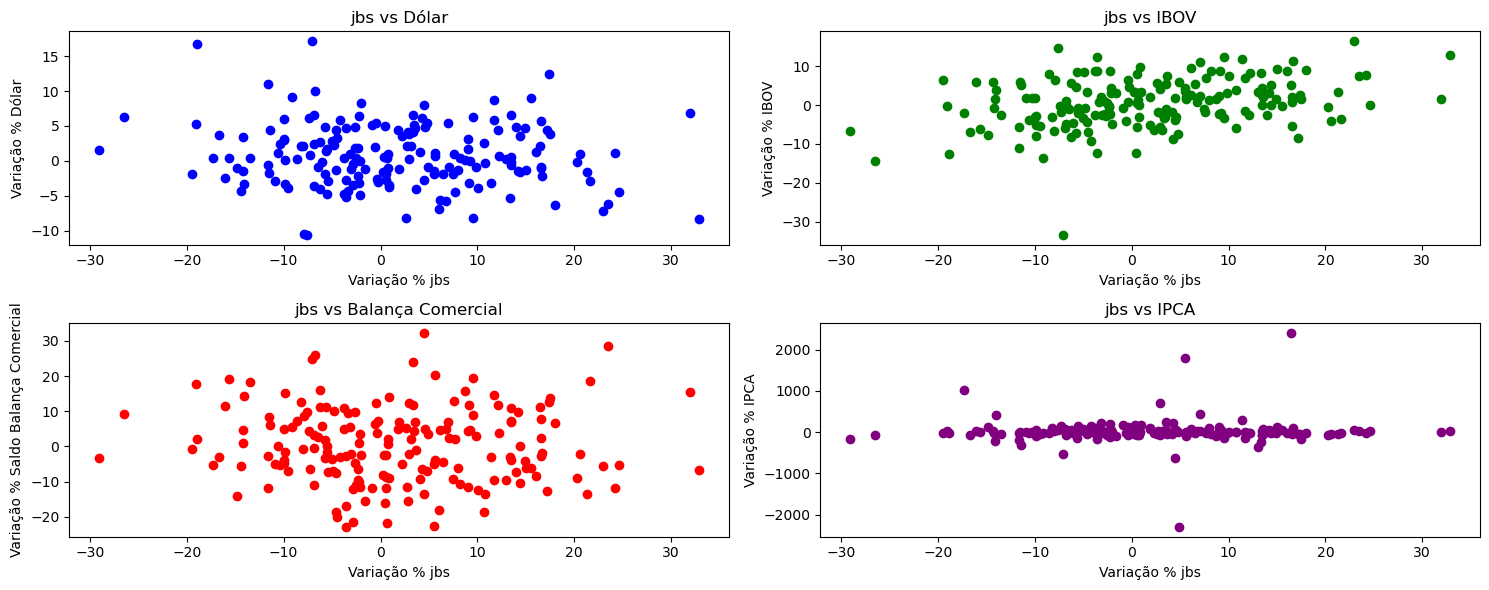

In [14]:
# Criar figura com 2 linhas e 2 colunas (4 grÃ¡ficos)
fig, ax = plt.subplots(2, 2, figsize=(15,6))

# 1. jbs vs DÃ³lar
ax[0, 0].scatter(df_final_var['var_%_jbs'], df_final_var['var_%_dolar'], color='blue')
ax[0, 0].set_title("jbs vs DÃ³lar")
ax[0, 0].set_xlabel("VariaÃ§Ã£o % jbs")
ax[0, 0].set_ylabel("VariaÃ§Ã£o % DÃ³lar")

# 2. jbs vs IBOV
ax[0, 1].scatter(df_final_var['var_%_jbs'], df_final_var['var_%_ibov'], color='green')
ax[0, 1].set_title("jbs vs IBOV")
ax[0, 1].set_xlabel("VariaÃ§Ã£o % jbs")
ax[0, 1].set_ylabel("VariaÃ§Ã£o % IBOV")

# 3. jbs vs BalanÃ§a Comercial
ax[1, 0].scatter(df_final_var['var_%_jbs'], df_final_var['var_%_balanca_com'], color='red')
ax[1, 0].set_title("jbs vs BalanÃ§a Comercial")
ax[1, 0].set_xlabel("VariaÃ§Ã£o % jbs")
ax[1, 0].set_ylabel("VariaÃ§Ã£o % Saldo BalanÃ§a Comercial")

# 4. jbs vs IPCA
ax[1, 1].scatter(df_final_var['var_%_jbs'], df_final_var['var_%_ipca'], color='purple')
ax[1, 1].set_title("jbs vs IPCA")
ax[1, 1].set_xlabel("VariaÃ§Ã£o % jbs")
ax[1, 1].set_ylabel("VariaÃ§Ã£o % IPCA")

plt.tight_layout()
plt.show()

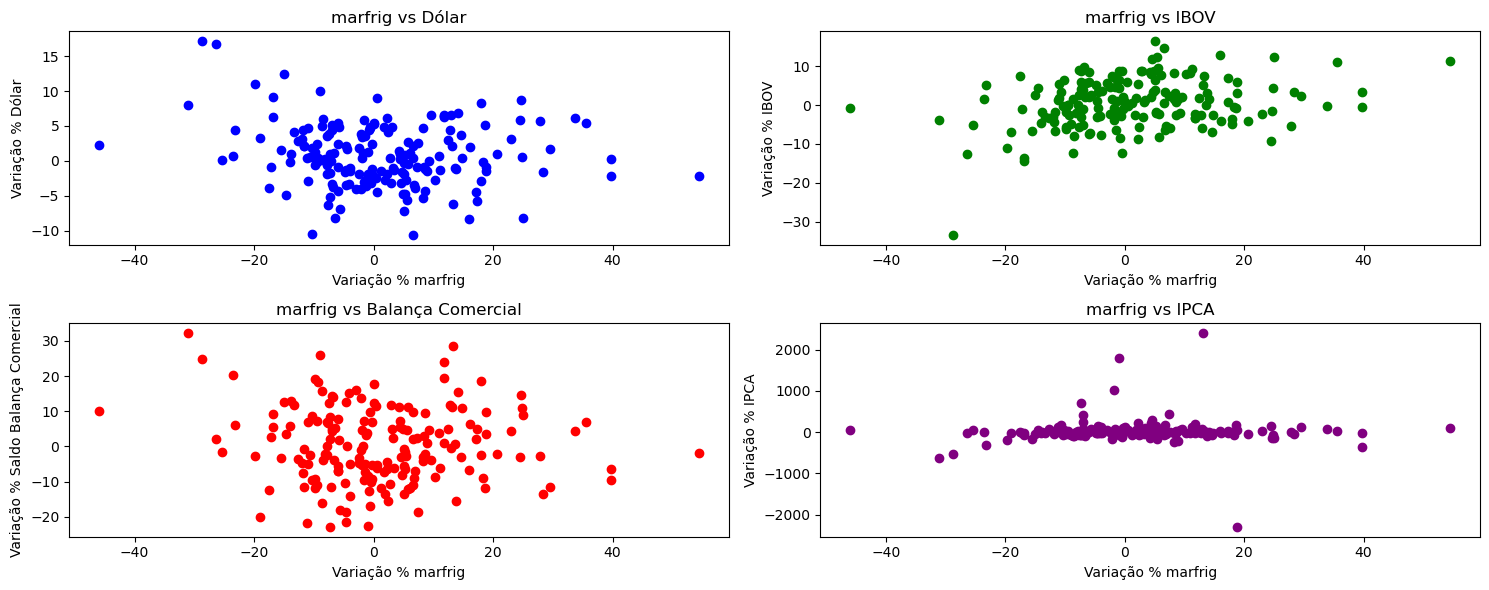

In [15]:
# Criar figura com 2 linhas e 2 colunas (4 grÃ¡ficos)
fig, ax = plt.subplots(2, 2, figsize=(15,6))

# 1. marfrig vs DÃ³lar
ax[0, 0].scatter(df_final_var['var_%_marfrig'], df_final_var['var_%_dolar'], color='blue')
ax[0, 0].set_title("marfrig vs DÃ³lar")
ax[0, 0].set_xlabel("VariaÃ§Ã£o % marfrig")
ax[0, 0].set_ylabel("VariaÃ§Ã£o % DÃ³lar")

# 2. marfrig vs IBOV
ax[0, 1].scatter(df_final_var['var_%_marfrig'], df_final_var['var_%_ibov'], color='green')
ax[0, 1].set_title("marfrig vs IBOV")
ax[0, 1].set_xlabel("VariaÃ§Ã£o % marfrig")
ax[0, 1].set_ylabel("VariaÃ§Ã£o % IBOV")

# 3. marfrig vs BalanÃ§a Comercial
ax[1, 0].scatter(df_final_var['var_%_marfrig'], df_final_var['var_%_balanca_com'], color='red')
ax[1, 0].set_title("marfrig vs BalanÃ§a Comercial")
ax[1, 0].set_xlabel("VariaÃ§Ã£o % marfrig")
ax[1, 0].set_ylabel("VariaÃ§Ã£o % Saldo BalanÃ§a Comercial")

# 4. marfrig vs IPCA
ax[1, 1].scatter(df_final_var['var_%_marfrig'], df_final_var['var_%_ipca'], color='purple')
ax[1, 1].set_title("marfrig vs IPCA")
ax[1, 1].set_xlabel("VariaÃ§Ã£o % marfrig")
ax[1, 1].set_ylabel("VariaÃ§Ã£o % IPCA")

plt.tight_layout()
plt.show()

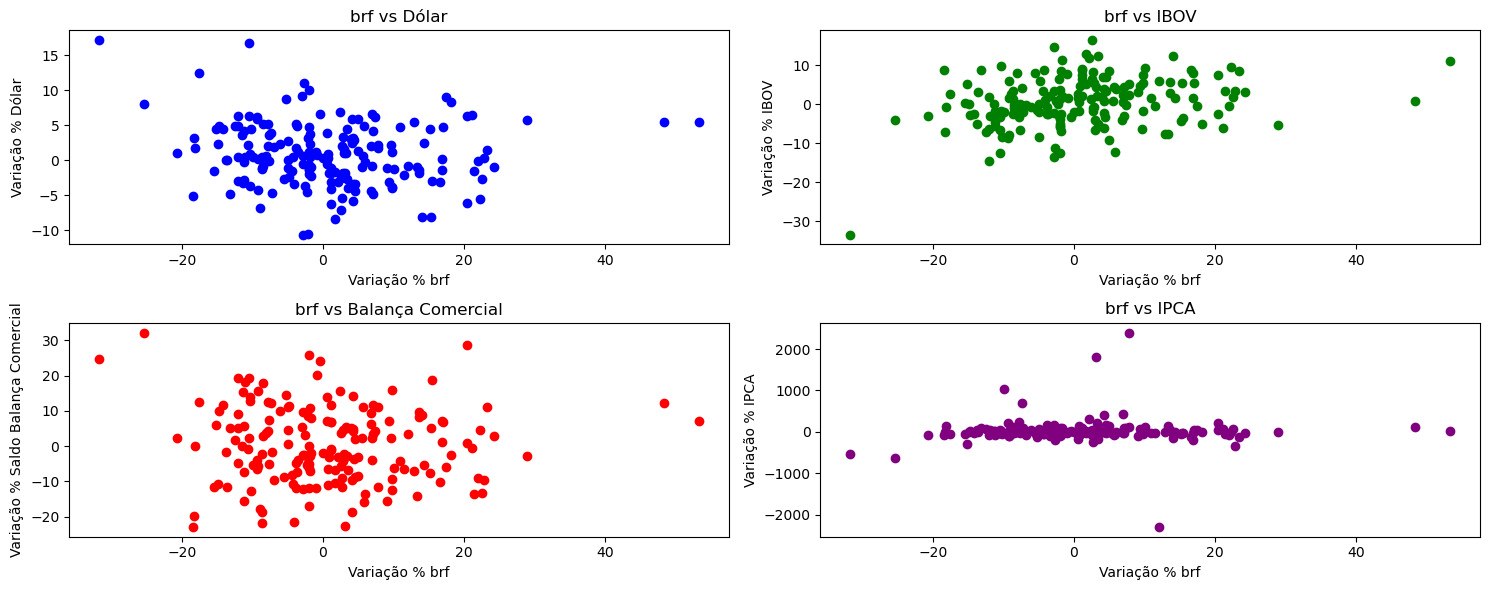

In [16]:
# Criar figura com 2 linhas e 2 colunas (4 grÃ¡ficos)
fig, ax = plt.subplots(2, 2, figsize=(15,6))

# 1. brf vs DÃ³lar
ax[0, 0].scatter(df_final_var['var_%_brf'], df_final_var['var_%_dolar'], color='blue')
ax[0, 0].set_title("brf vs DÃ³lar")
ax[0, 0].set_xlabel("VariaÃ§Ã£o % brf")
ax[0, 0].set_ylabel("VariaÃ§Ã£o % DÃ³lar")

# 2. brf vs IBOV
ax[0, 1].scatter(df_final_var['var_%_brf'], df_final_var['var_%_ibov'], color='green')
ax[0, 1].set_title("brf vs IBOV")
ax[0, 1].set_xlabel("VariaÃ§Ã£o % brf")
ax[0, 1].set_ylabel("VariaÃ§Ã£o % IBOV")

# 3. brf vs BalanÃ§a Comercial
ax[1, 0].scatter(df_final_var['var_%_brf'], df_final_var['var_%_balanca_com'], color='red')
ax[1, 0].set_title("brf vs BalanÃ§a Comercial")
ax[1, 0].set_xlabel("VariaÃ§Ã£o % brf")
ax[1, 0].set_ylabel("VariaÃ§Ã£o % Saldo BalanÃ§a Comercial")

# 4. brf vs IPCA
ax[1, 1].scatter(df_final_var['var_%_brf'], df_final_var['var_%_ipca'], color='purple')
ax[1, 1].set_title("brf vs IPCA")
ax[1, 1].set_xlabel("VariaÃ§Ã£o % brf")
ax[1, 1].set_ylabel("VariaÃ§Ã£o % IPCA")

plt.tight_layout()
plt.show()

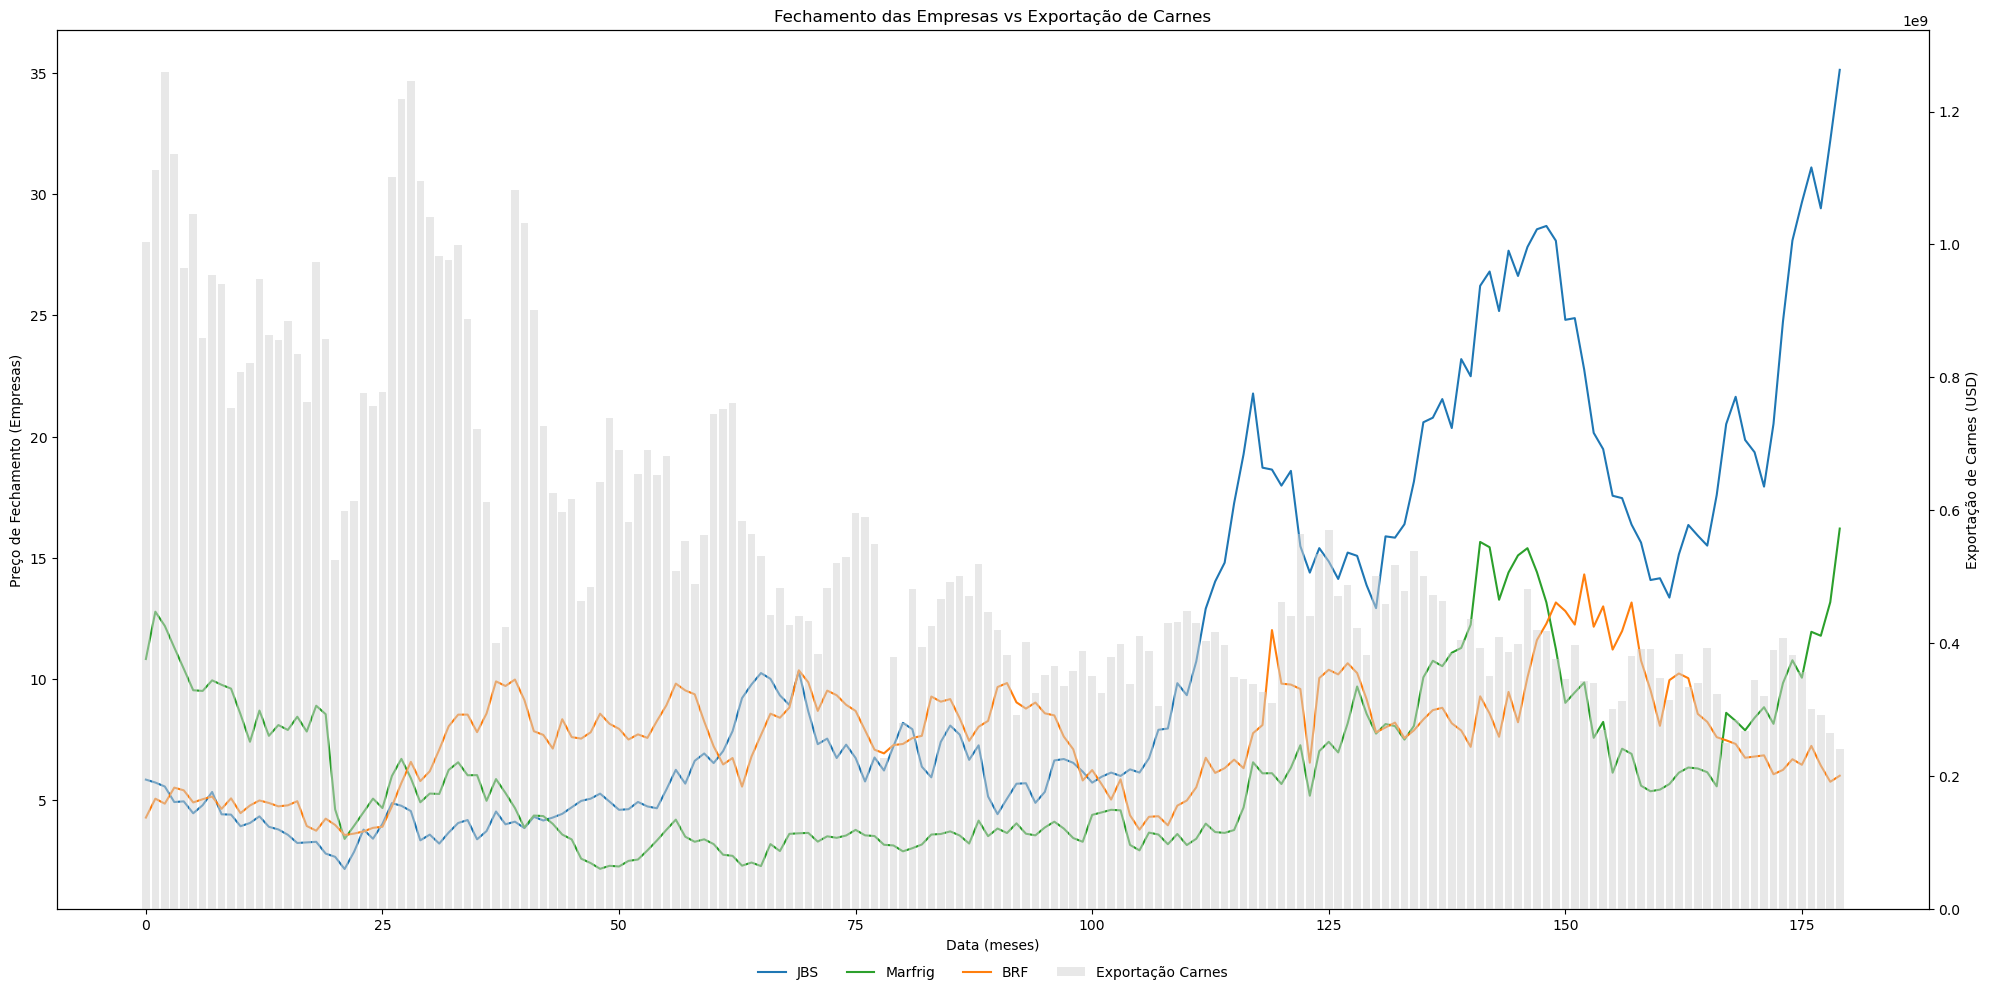

In [17]:
fig, ax1 = plt.subplots(figsize=(20, 10))

#eixo 2: Barras para exportaÃ§Ãµes
ax2 = ax1.twinx()
ax2.bar(
    range(len(df_balanca_carnes)),
    df_balanca_carnes.value_exp_carnes,
    alpha=0.5,
    color='#d3d3d3',
    label='ExportaÃ§Ã£o Carnes'
)
ax2.set_ylabel("ExportaÃ§Ã£o de Carnes (USD)")

#eixo 1: Linhas para empresas
ax1.plot(range(len(df_jbs)), df_jbs.close_jbs, color='#1f77b4', label='JBS')
ax1.plot(range(len(df_marfrig)), df_marfrig.close_marfrig, color='#2ca02c', label='Marfrig')
ax1.plot(range(len(df_brf)), df_brf.close_brf, color='#ff7f0e', label='BRF')

ax1.set_ylabel("PreÃ§o de Fechamento (Empresas)")
ax1.set_xlabel("Data (meses)")
ax1.legend(loc="upper left")

#tÃ­tulo geral
plt.title("Fechamento das Empresas vs ExportaÃ§Ã£o de Carnes")

#legendas combinadas (manual)
lines_labels = ax1.get_legend_handles_labels()[0] + ax2.get_legend_handles_labels()[0]
labels = ax1.get_legend_handles_labels()[1] + ax2.get_legend_handles_labels()[1]
ax1.legend(
    lines_labels,
    labels,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.05),  # centralizado e abaixo do grÃ¡fico
    ncol=4,                       # 4 colunas na legenda (ajuste conforme necessÃ¡rio)
    frameon=False                 # remove a borda da legenda (opcional)
)

plt.tight_layout()
plt.show()


## Modelo de regressÃ£o linear

### separar dados em treino e teste para cada empresa

In [ ]:
#separar os dados de entrada e os 3 alvos
X = df_final_value.drop(columns=['data', 'close_marfrig', 'close_jbs', 'close_brf', 'value_exp_carnes'])

y_jbs = df_final_value['close_jbs']
y_marfrig = df_final_value['close_marfrig']
y_brf = df_final_value['close_brf']

#fazer apenas UMA divisÃ£o (split) e use os mesmos Ã­ndices para todos os y
X_train, X_test, idx_train, idx_test = train_test_split(X, X.index, test_size=0.25, random_state=42)

#dividir os alvos com os mesmos Ã­ndices
y_jbs_train = y_jbs.loc[idx_train]
y_jbs_test = y_jbs.loc[idx_test]

y_marfrig_train = y_marfrig.loc[idx_train]
y_marfrig_test = y_marfrig.loc[idx_test]

y_brf_train = y_brf.loc[idx_train]
y_brf_test = y_brf.loc[idx_test]

### regressÃ£o linear simples


ðŸ”¹ðŸ”¹ðŸ”¹ RegressÃ£o Linear Simples para JBS ðŸ”¹ðŸ”¹ðŸ”¹

ðŸ“ˆ VariÃ¡vel: close_dolar
  RÂ² teste: 0.6360
  EMA: 3.78
  EQM: 21.11

ðŸ“ˆ VariÃ¡vel: close_ibov
  RÂ² teste: 0.7125
  EMA: 3.39
  EQM: 16.68

ðŸ“ˆ VariÃ¡vel: value_ipca
  RÂ² teste: -0.0422
  EMA: 6.69
  EQM: 60.45

ðŸ“ˆ VariÃ¡vel: saldo_balanca_com
  RÂ² teste: 0.1261
  EMA: 5.74
  EQM: 50.69


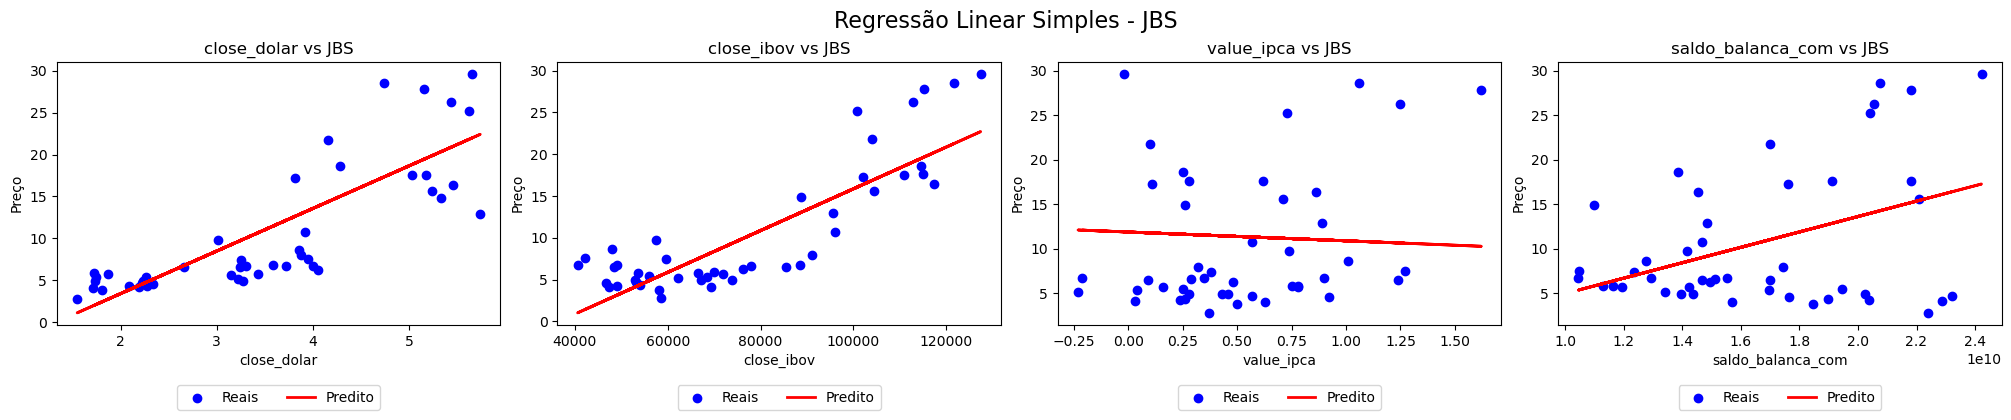


ðŸ”¹ðŸ”¹ðŸ”¹ RegressÃ£o Linear Simples para Marfrig ðŸ”¹ðŸ”¹ðŸ”¹

ðŸ“ˆ VariÃ¡vel: close_dolar
  RÂ² teste: 0.0665
  EMA: 2.94
  EQM: 12.60

ðŸ“ˆ VariÃ¡vel: close_ibov
  RÂ² teste: 0.2823
  EMA: 2.36
  EQM: 9.69

ðŸ“ˆ VariÃ¡vel: value_ipca
  RÂ² teste: 0.0510
  EMA: 3.01
  EQM: 12.81

ðŸ“ˆ VariÃ¡vel: saldo_balanca_com
  RÂ² teste: 0.0489
  EMA: 2.88
  EQM: 12.84


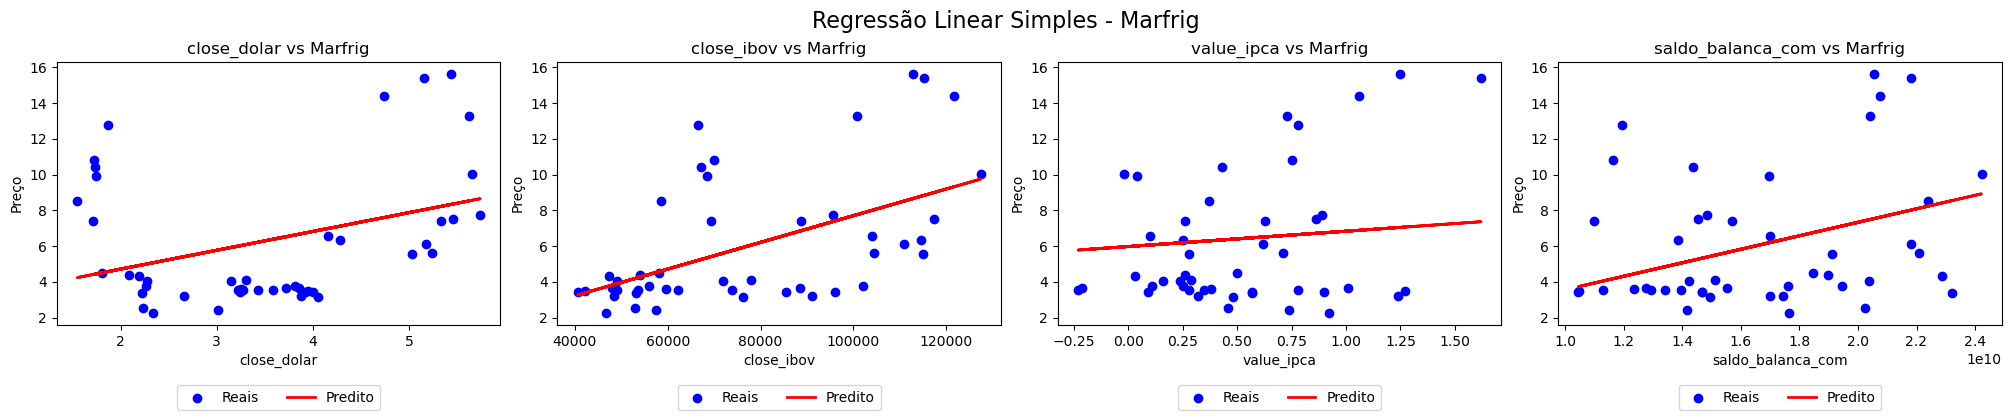


ðŸ”¹ðŸ”¹ðŸ”¹ RegressÃ£o Linear Simples para BRF ðŸ”¹ðŸ”¹ðŸ”¹

ðŸ“ˆ VariÃ¡vel: close_dolar
  RÂ² teste: 0.2515
  EMA: 1.52
  EQM: 3.10

ðŸ“ˆ VariÃ¡vel: close_ibov
  RÂ² teste: 0.0343
  EMA: 1.67
  EQM: 4.00

ðŸ“ˆ VariÃ¡vel: value_ipca
  RÂ² teste: -0.0955
  EMA: 1.67
  EQM: 4.54

ðŸ“ˆ VariÃ¡vel: saldo_balanca_com
  RÂ² teste: -0.0132
  EMA: 1.66
  EQM: 4.20


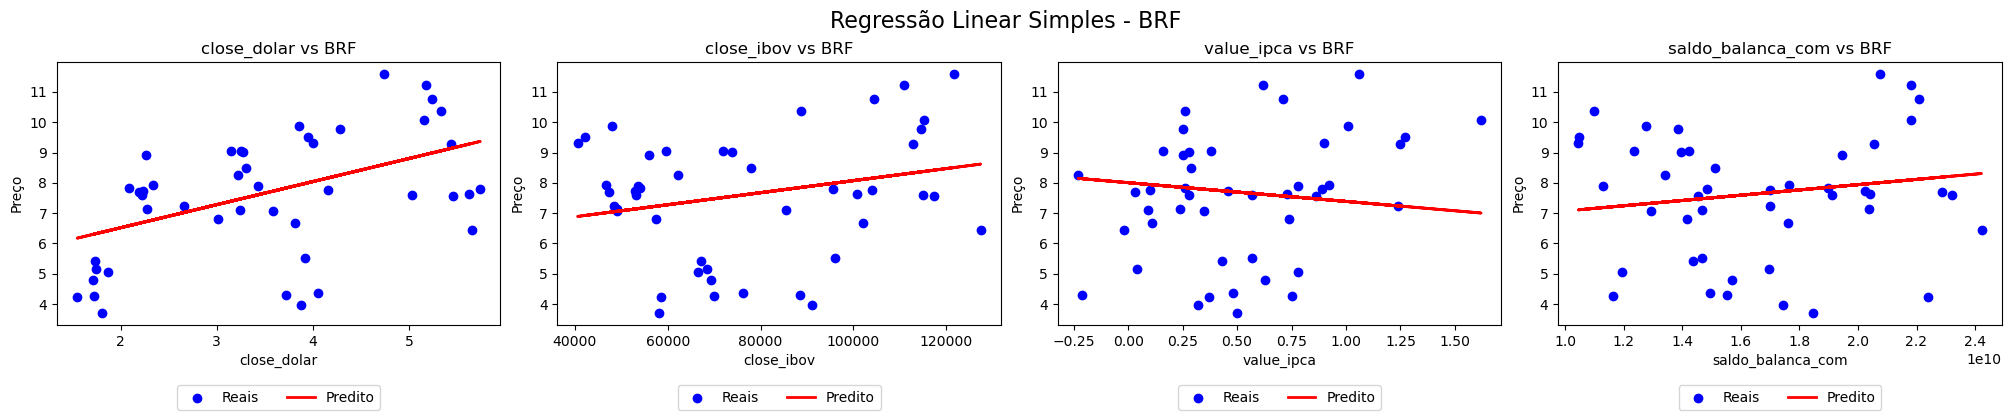

In [44]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# DicionÃ¡rio com os dados de cada empresa
empresas = {
    'JBS': (y_jbs_train, y_jbs_test),
    'Marfrig': (y_marfrig_train, y_marfrig_test),
    'BRF': (y_brf_train, y_brf_test)
}

# Para cada empresa
for nome_empresa, (y_train, y_test) in empresas.items():
    print(f"\nðŸ”¹ðŸ”¹ðŸ”¹ RegressÃ£o Linear Simples para {nome_empresa} ðŸ”¹ðŸ”¹ðŸ”¹")

    variaveis = X_train.columns.tolist()
    n_vars = len(variaveis)

    # Criar subplots (1 linha, n colunas)
    fig, axs = plt.subplots(1, n_vars, figsize=(5 * n_vars, 4), constrained_layout=True)

    for i, col in enumerate(variaveis):
        X_s_train = X_train[[col]]
        X_s_test = X_test[[col]]

        modelo = LinearRegression().fit(X_s_train, y_train)
        y_pred = modelo.predict(X_s_test)

        # AvaliaÃ§Ã£o
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)

        print(f"\nðŸ“ˆ VariÃ¡vel: {col}")
        print(f"  RÂ² teste: {r2:.4f}")
        print(f"  EMA: {mae:.2f}")
        print(f"  EQM: {mse:.2f}")

        # Plot no subplot correspondente
        ax = axs[i]
        ax.scatter(X_s_test, y_test, color='blue', label='Reais')
        ax.plot(X_s_test, y_pred, color='red', linewidth=2, label='Predito')
        ax.set_xlabel(col)
        ax.set_ylabel("PreÃ§o")
        ax.set_title(f"{col} vs {nome_empresa}")
        ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.35), ncol=2)

    # TÃ­tulo geral
    fig.suptitle(f"RegressÃ£o Linear Simples - {nome_empresa}", fontsize=16)
    plt.show()


### regressao linear multipla


ðŸ”·ðŸ”·ðŸ”· RegressÃ£o Linear MÃºltipla para JBS ðŸ”·ðŸ”·ðŸ”·

ðŸ“ˆ JBS - VariÃ¡veis: ('close_dolar', 'close_ibov')
  RÂ² treino: 82.87%
  RÂ² teste: 77.38%
  EMA: 2.86
  EQM: 13.12

ðŸ“ˆ JBS - VariÃ¡veis: ('close_dolar', 'value_ipca')
  RÂ² treino: 77.26%
  RÂ² teste: 63.85%
  EMA: 3.78
  EQM: 20.97

ðŸ“ˆ JBS - VariÃ¡veis: ('close_dolar', 'saldo_balanca_com')
  RÂ² treino: 84.90%
  RÂ² teste: 73.25%
  EMA: 3.22
  EQM: 15.52

ðŸ“ˆ JBS - VariÃ¡veis: ('close_ibov', 'value_ipca')
  RÂ² treino: 73.68%
  RÂ² teste: 71.80%
  EMA: 3.37
  EQM: 16.36

ðŸ“ˆ JBS - VariÃ¡veis: ('close_ibov', 'saldo_balanca_com')
  RÂ² treino: 74.35%
  RÂ² teste: 72.13%
  EMA: 3.28
  EQM: 16.16

ðŸ“ˆ JBS - VariÃ¡veis: ('value_ipca', 'saldo_balanca_com')
  RÂ² treino: 15.13%
  RÂ² teste: 10.94%
  EMA: 5.81
  EQM: 51.65

ðŸ“ˆ JBS - VariÃ¡veis: ('close_dolar', 'close_ibov', 'value_ipca')
  RÂ² treino: 82.95%
  RÂ² teste: 78.22%
  EMA: 2.83
  EQM: 12.63

ðŸ“ˆ JBS - VariÃ¡veis: ('close_dolar', 'close_ibov', 'saldo_bal

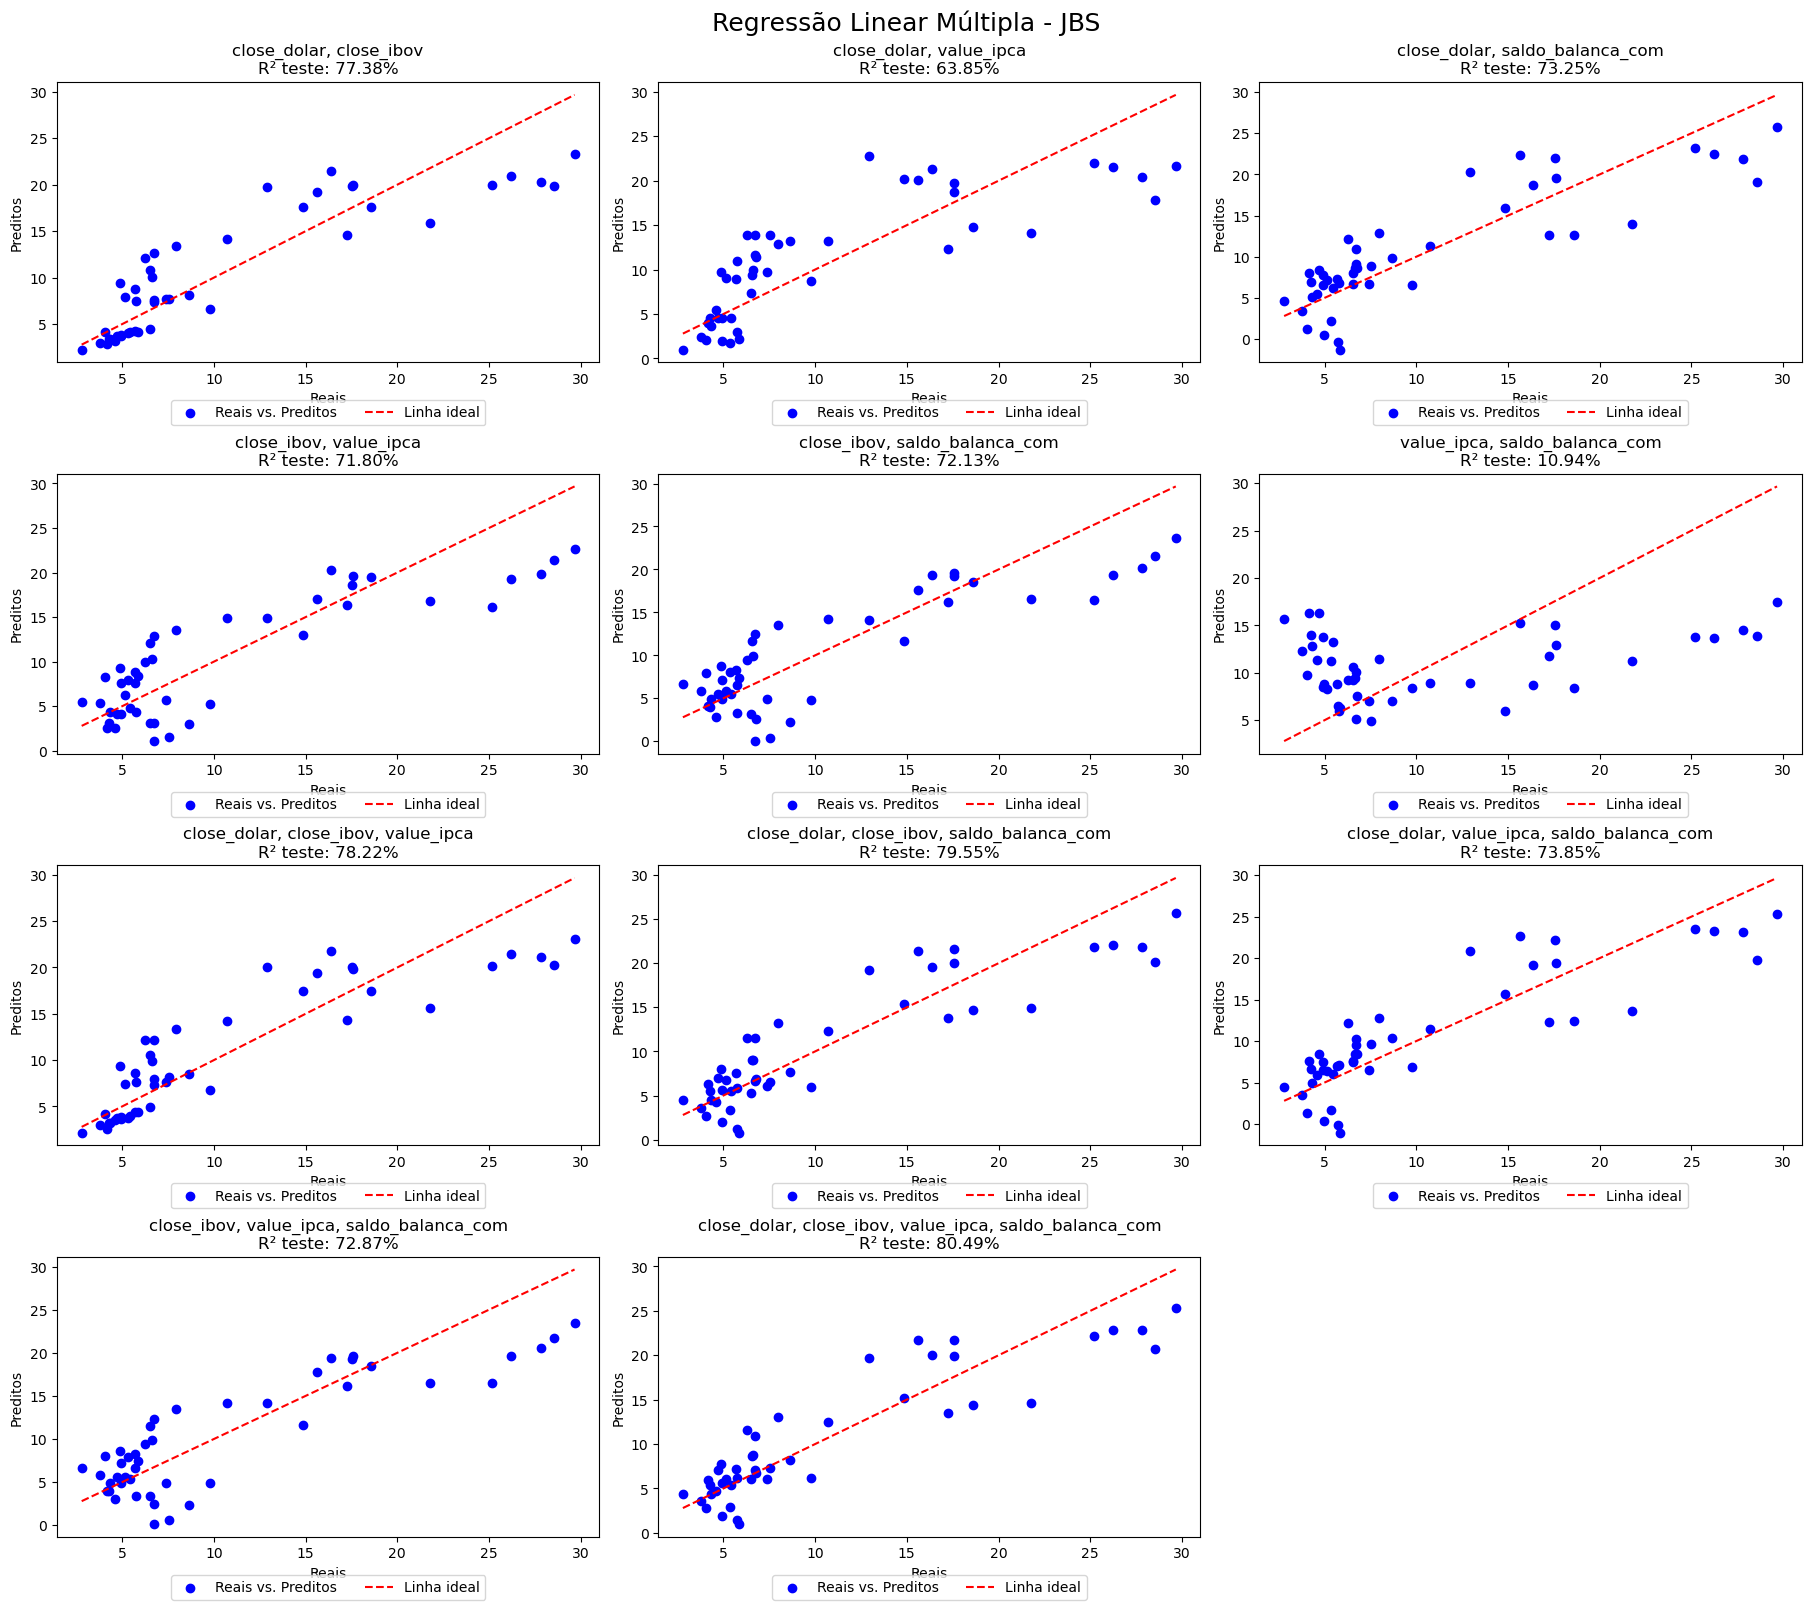


ðŸ”·ðŸ”·ðŸ”· RegressÃ£o Linear MÃºltipla para Marfrig ðŸ”·ðŸ”·ðŸ”·

ðŸ“ˆ Marfrig - VariÃ¡veis: ('close_dolar', 'close_ibov')
  RÂ² treino: 43.07%
  RÂ² teste: 30.77%
  EMA: 2.37
  EQM: 9.34

ðŸ“ˆ Marfrig - VariÃ¡veis: ('close_dolar', 'value_ipca')
  RÂ² treino: 22.57%
  RÂ² teste: 11.80%
  EMA: 2.88
  EQM: 11.90

ðŸ“ˆ Marfrig - VariÃ¡veis: ('close_dolar', 'saldo_balanca_com')
  RÂ² treino: 34.58%
  RÂ² teste: 11.73%
  EMA: 2.68
  EQM: 11.91

ðŸ“ˆ Marfrig - VariÃ¡veis: ('close_ibov', 'value_ipca')
  RÂ² treino: 43.10%
  RÂ² teste: 36.14%
  EMA: 2.32
  EQM: 8.62

ðŸ“ˆ Marfrig - VariÃ¡veis: ('close_ibov', 'saldo_balanca_com')
  RÂ² treino: 45.67%
  RÂ² teste: 28.01%
  EMA: 2.41
  EQM: 9.72

ðŸ“ˆ Marfrig - VariÃ¡veis: ('value_ipca', 'saldo_balanca_com')
  RÂ² treino: 19.36%
  RÂ² teste: 12.27%
  EMA: 2.82
  EQM: 11.84

ðŸ“ˆ Marfrig - VariÃ¡veis: ('close_dolar', 'close_ibov', 'value_ipca')
  RÂ² treino: 44.52%
  RÂ² teste: 39.29%
  EMA: 2.25
  EQM: 8.19

ðŸ“ˆ Marfrig - VariÃ¡veis: ('close_

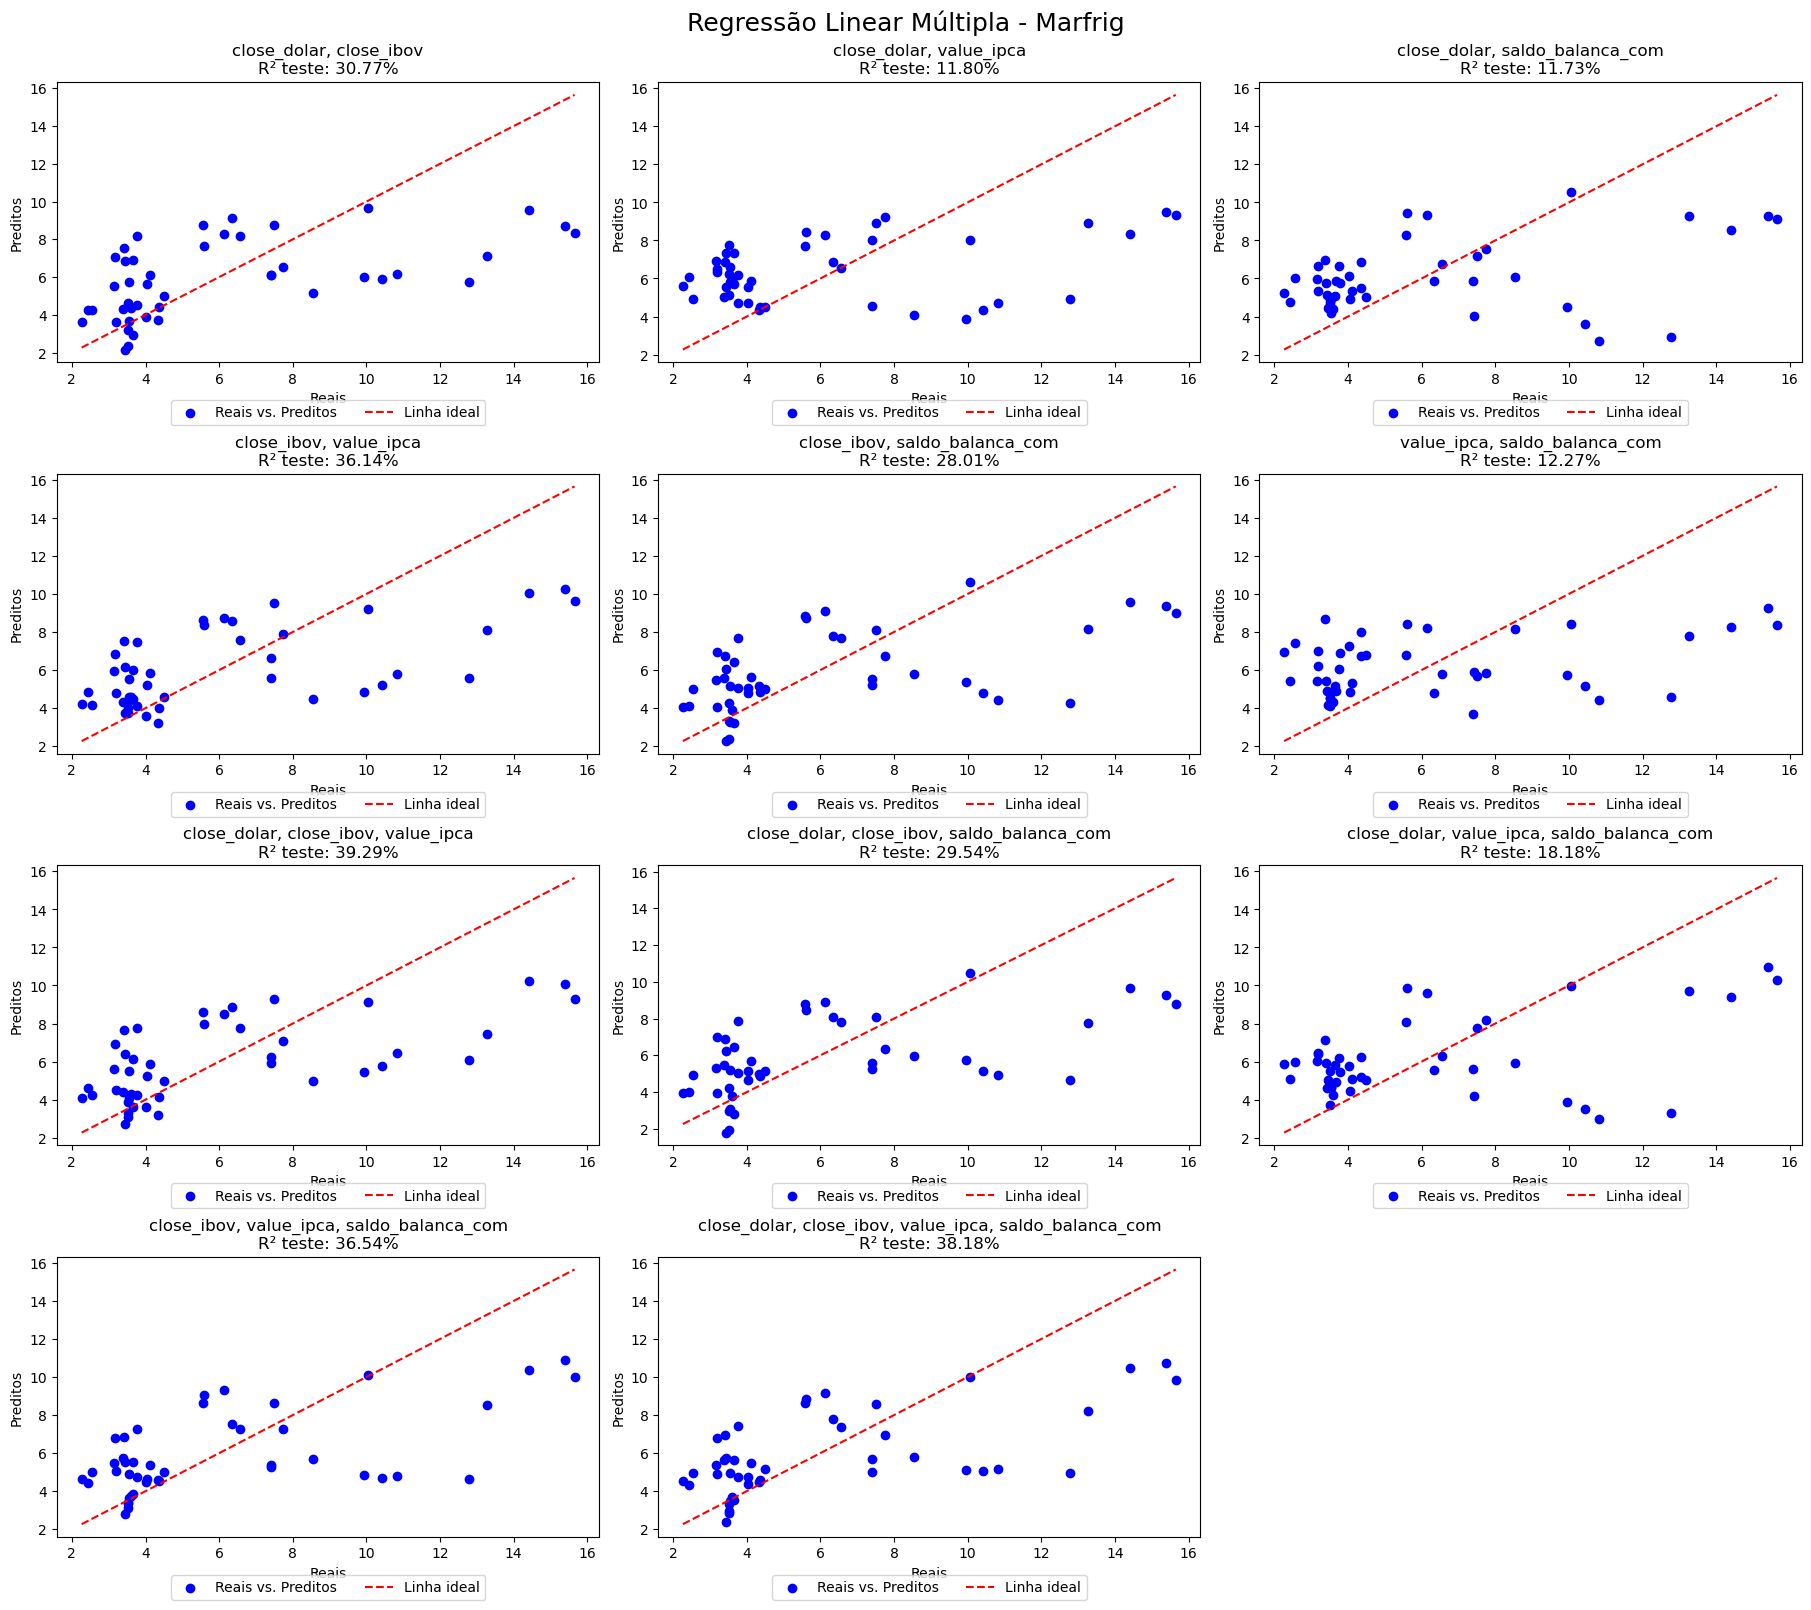


ðŸ”·ðŸ”·ðŸ”· RegressÃ£o Linear MÃºltipla para BRF ðŸ”·ðŸ”·ðŸ”·

ðŸ“ˆ BRF - VariÃ¡veis: ('close_dolar', 'close_ibov')
  RÂ² treino: 27.90%
  RÂ² teste: 30.65%
  EMA: 1.33
  EQM: 2.87

ðŸ“ˆ BRF - VariÃ¡veis: ('close_dolar', 'value_ipca')
  RÂ² treino: 22.01%
  RÂ² teste: 22.02%
  EMA: 1.55
  EQM: 3.23

ðŸ“ˆ BRF - VariÃ¡veis: ('close_dolar', 'saldo_balanca_com')
  RÂ² treino: 22.36%
  RÂ² teste: 24.69%
  EMA: 1.51
  EQM: 3.12

ðŸ“ˆ BRF - VariÃ¡veis: ('close_ibov', 'value_ipca')
  RÂ² treino: 6.47%
  RÂ² teste: -3.86%
  EMA: 1.73
  EQM: 4.31

ðŸ“ˆ BRF - VariÃ¡veis: ('close_ibov', 'saldo_balanca_com')
  RÂ² treino: 6.14%
  RÂ² teste: 2.94%
  EMA: 1.66
  EQM: 4.02

ðŸ“ˆ BRF - VariÃ¡veis: ('value_ipca', 'saldo_balanca_com')
  RÂ² treino: 2.65%
  RÂ² teste: -9.46%
  EMA: 1.73
  EQM: 4.54

ðŸ“ˆ BRF - VariÃ¡veis: ('close_dolar', 'close_ibov', 'value_ipca')
  RÂ² treino: 28.13%
  RÂ² teste: 29.13%
  EMA: 1.34
  EQM: 2.94

ðŸ“ˆ BRF - VariÃ¡veis: ('close_dolar', 'close_ibov', 'saldo_balanca_com')


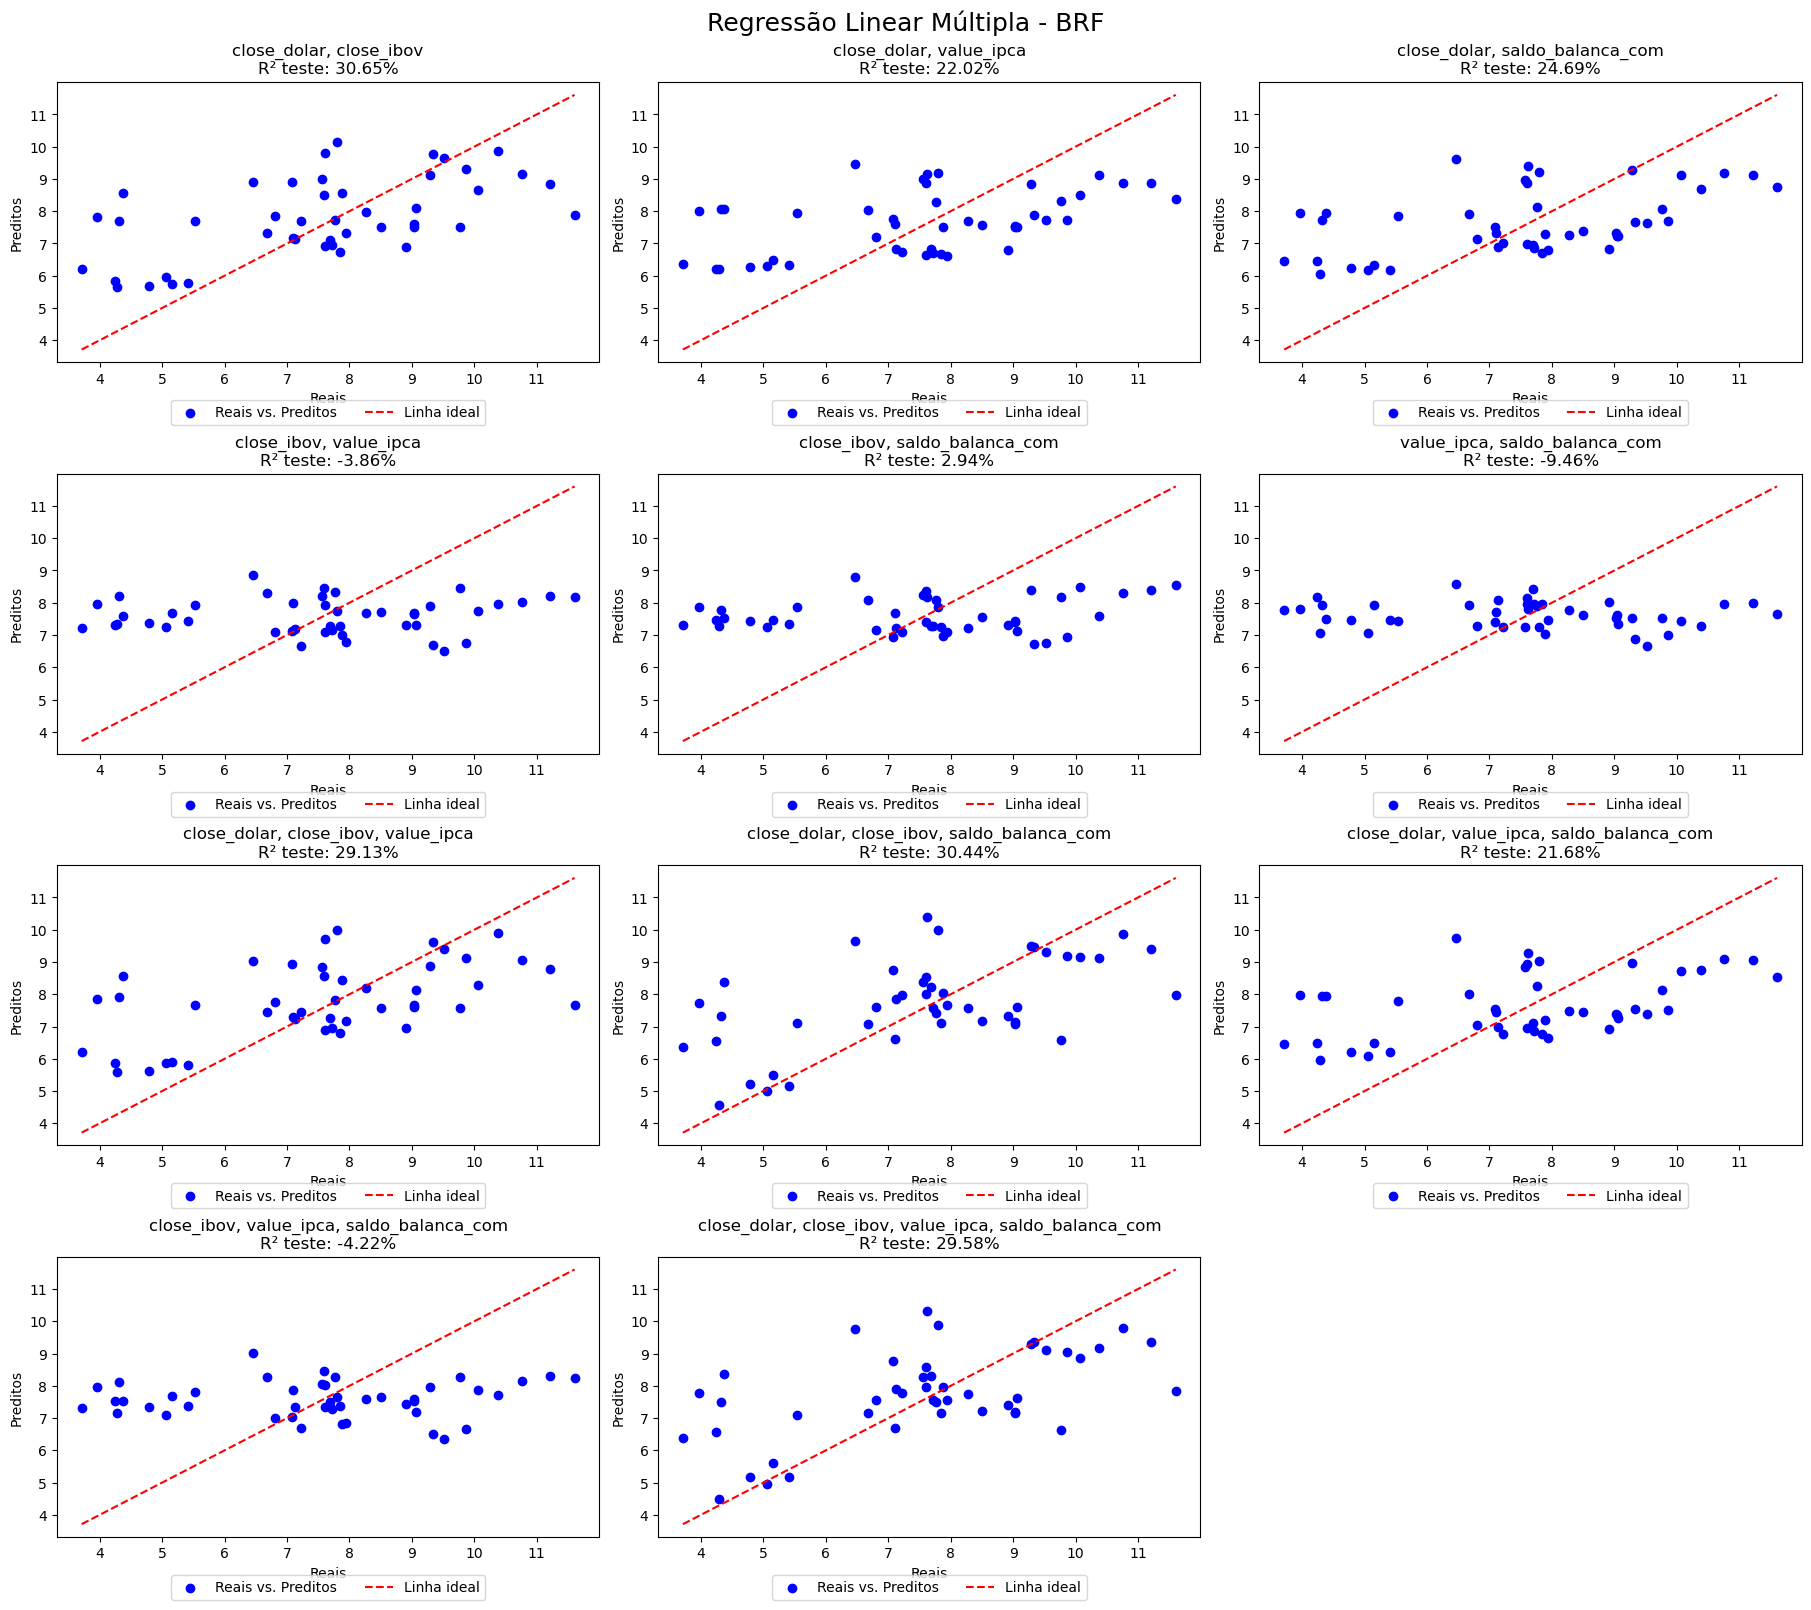

In [52]:
#dados de saÃ­da de cada empresa
empresas = {
    'JBS': (y_jbs_train, y_jbs_test),
    'Marfrig': (y_marfrig_train, y_marfrig_test),
    'BRF': (y_brf_train, y_brf_test)
}

#loop para cada empresa
for nome_empresa, (y_train, y_test) in empresas.items():
    print(f"\nðŸ”·ðŸ”·ðŸ”· RegressÃ£o Linear MÃºltipla para {nome_empresa} ðŸ”·ðŸ”·ðŸ”·")

    #gerar todas as combinaÃ§Ãµes de 2 a 4 variÃ¡veis
    combinacoes = []
    for k in range(2, len(X_train.columns) + 1):
        combinacoes.extend(list(combinations(X_train.columns, k)))

    n_combos = len(combinacoes)
    n_cols = 3  # nÃºmero de grÃ¡ficos por linha
    n_rows = math.ceil(n_combos / n_cols)

    # Criar subplots para todos os grÃ¡ficos dessa empresa
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows), constrained_layout=True)
    axs = axs.flatten()  # achata a matriz para indexaÃ§Ã£o simples

    #loop pelas combinaÃ§Ãµes
    for idx, combo in enumerate(combinacoes):
        X_mult_train = X_train[list(combo)]
        X_mult_test = X_test[list(combo)]

        modelo = LinearRegression().fit(X_mult_train, y_train)
        y_pred = modelo.predict(X_mult_test)

        #avaliaÃ§Ã£o
        r2_treino = modelo.score(X_mult_train, y_train)
        r2_teste = modelo.score(X_mult_test, y_test)
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)

        #impressÃ£o das mÃ©tricas no terminal
        print(f"\nðŸ“ˆ {nome_empresa} - VariÃ¡veis: {combo}")
        print(f"  RÂ² treino: {r2_treino * 100:.2f}%")
        print(f"  RÂ² teste: {r2_teste * 100:.2f}%")
        print(f"  EMA: {mae:.2f}")
        print(f"  EQM: {mse:.2f}")

        #grÃ¡fico no subplot correspondente
        ax = axs[idx]
        ax.scatter(y_test, y_pred, color='blue', label='Reais vs. Preditos')
        ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Linha ideal')
        ax.set_xlabel("Reais")
        ax.set_ylabel("Preditos")
        ax.set_title(f"{', '.join(combo)}\nRÂ² teste: {r2_teste*100:.2f}%")
        ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=2)

    #apagar subplots vazios
    for j in range(idx + 1, len(axs)):
        fig.delaxes(axs[j])

    #tÃ­tulo geral
    fig.suptitle(f"RegressÃ£o Linear MÃºltipla - {nome_empresa}", fontsize=18)
    plt.show()


## modelo que mais se adapta - retirar variÃ¡veis desnecessÃ¡rias

In [1]:
'''#alvos em dicionÃ¡rio
targets = {
    'JBS': (y_jbs_train, y_jbs_test),
    'Marfrig': (y_marfrig_train, y_marfrig_test),
    'BRF': (y_brf_train, y_brf_test)
}
#loop para cada empresa
for nome, (y_train, y_test) in targets.items():
    # Treinar modelo
    modelo = LinearRegression()
    modelo.fit(X_train, y_train)
    
    #previsÃµes
    y_pred = modelo.predict(X_test)
    
    #avaliaÃ§Ã£o
    r2 = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred)
    
    print(f"\nðŸ“Š Resultados para {nome}:")
    print(f"RÂ²: {r2:.4f}")
    print(f"RMSE: {rmse:.2f}")
    
    #plot (opcional)
    plt.figure(figsize=(6,4))
    plt.scatter(y_test, y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Valores reais")
    plt.ylabel("Valores preditos")
    plt.title(f"{nome} - Reais vs. Preditos")
    plt.grid(True)
    plt.tight_layout()
    plt.show()'''

'#alvos em dicionÃ¡rio\ntargets = {\n    \'JBS\': (y_jbs_train, y_jbs_test),\n    \'Marfrig\': (y_marfrig_train, y_marfrig_test),\n    \'BRF\': (y_brf_train, y_brf_test)\n}\n#loop para cada empresa\nfor nome, (y_train, y_test) in targets.items():\n    # Treinar modelo\n    modelo = LinearRegression()\n    modelo.fit(X_train, y_train)\n\n    #previsÃµes\n    y_pred = modelo.predict(X_test)\n\n    #avaliaÃ§Ã£o\n    r2 = r2_score(y_test, y_pred)\n    rmse = mean_squared_error(y_test, y_pred)\n\n    print(f"\nðŸ“Š Resultados para {nome}:")\n    print(f"RÂ²: {r2:.4f}")\n    print(f"RMSE: {rmse:.2f}")\n\n    #plot (opcional)\n    plt.figure(figsize=(6,4))\n    plt.scatter(y_test, y_pred)\n    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], \'r--\')\n    plt.xlabel("Valores reais")\n    plt.ylabel("Valores preditos")\n    plt.title(f"{nome} - Reais vs. Preditos")\n    plt.grid(True)\n    plt.tight_layout()\n    plt.show()'